In [1]:
!pip install gdown

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import pickle
import gdown
import random

from PIL import Image
from glob import glob
from skimage import transform,color


from skimage.util import img_as_ubyte

from tqdm import tqdm
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_curve,auc,RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [3]:
data_path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

parasitized = glob(os.path.join(data_path,'Parasitized','*.png'))
uninfected = glob(os.path.join(data_path,'Uninfected','*.png'))

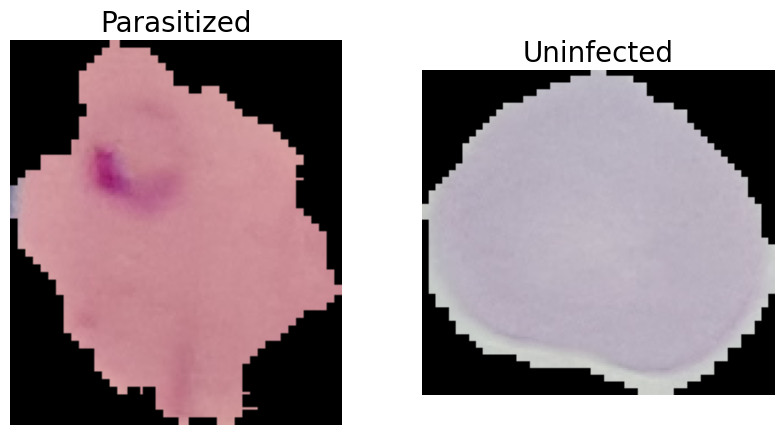

In [5]:
sample_parasitized = Image.open(parasitized[0])
sample_uninfected = Image.open(uninfected[0])

fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(sample_parasitized)
axes[0].axis('off')
axes[0].set_title('Parasitized',fontsize=20)
axes[1].imshow(sample_uninfected)
axes[1].axis('off')
axes[1].set_title('Uninfected',fontsize=20)

plt.savefig('data_sample.jpg')

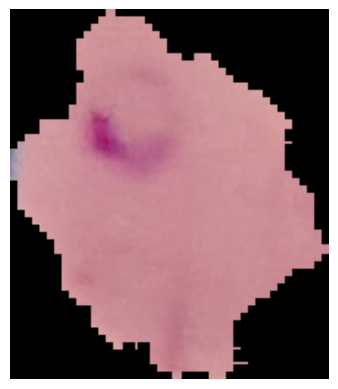

In [9]:
sample_parasitized = Image.open(parasitized[0])

plt.imshow(sample_parasitized)
plt.axis('off')
plt.savefig('original_img.jpg')

In [4]:
def resize_img(path,shape):
    target_shape = shape
    img = Image.open(path)
    actual_shape = img.size
    aspect_ratio = float(target_shape)/max(actual_shape)
    new_shape = tuple([int(aspect_ratio * shape) for shape in actual_shape])
    new_img = Image.new('RGB',(target_shape,target_shape))
    
    new_img.paste(img,((target_shape-new_shape[0])//2
                       ,(target_shape-new_shape[1])//2))
    
    
    return new_img

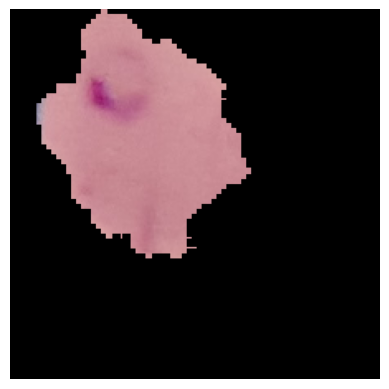

In [5]:
resized_img = resize_img(parasitized[0],224)
plt.axis('off')
plt.imshow(resized_img,cmap='Greys_r')

plt.savefig('resized_img.jpg')

In [5]:
def brighten_background_pixel(img):
    
    max_pixel = np.max(img)
    img[img==0.0] = max_pixel
    
    return img

In [6]:
resized_img = np.array(resized_img)
grey_img = color.rgb2gray(resized_img)
plt.axis('off')
plt.imshow(grey_img,cmap='Greys_r')
plt.savefig('grey_img.jpg')

NameError: name 'resized_img' is not defined

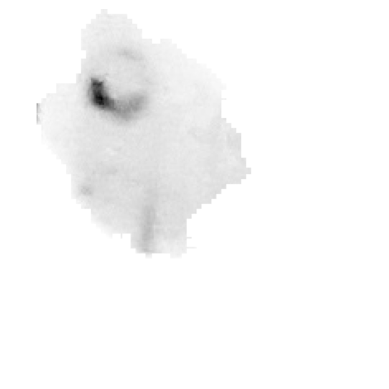

In [8]:
brighten_parisitized_img = brighten_background_pixel(grey_img)
plt.imshow(brighten_parisitized_img,cmap='Greys_r')
plt.axis('off')
plt.savefig('background_inversion.jpg')

In [8]:
# img_ = resize_img(parasitized[0],224)
# img_ = color.rgb2gray(img_)

# local_ = threshold_local(brighten_parisitized_img,15,'mean')

# otsu_thres = img_ >= local_

# plt.imshow(otsu_thres,cmap='Greys_r')

In [9]:
# # img_ = resize_img(parasitized[0],224)
# # img_ = color.rgb2gray(img_)

# entropy_ = entropy(img_as_ubyte(brighten_parisitized_img),disk(5))
# plt.imshow(entropy_,cmap='Greys_r')

In [6]:
def preprocessing(image_path):
    resized_img = resize_img(image_path,shape=224)
    resized_img = np.array(resized_img)
    grey_img = color.rgb2gray(resized_img)
    brighten_img =  brighten_background_pixel(grey_img.reshape(-1))
    return brighten_img

In [7]:
def feature_extraction(image_path):

    preprocessed_image = preprocessing(image_path)
    img = transform.resize(preprocessed_image.reshape(224,224),(100,100))
    img_feature =  img.reshape(-1)
    
    return img_feature

In [11]:
image_pos_feature = []
progress = tqdm(range(len(parasitized)))
for img_path in parasitized:
    image_feature = feature_extraction(img_path)
    image_pos_feature.append(image_feature)
    progress.update(1)

100%|█████████▉| 13772/13779 [02:24<00:00, 96.15it/s] 

In [12]:
image_pos_feature = np.array(image_pos_feature)
image_pos_feature.shape

(13779, 10000)

In [13]:
image_neg_feature = []
progress_2 = tqdm(range(len(uninfected)))
for img_path in uninfected:
    image_feature = feature_extraction(img_path)
    image_neg_feature.append(image_feature)
    progress_2.update(1) 


100%|█████████▉| 13776/13779 [02:31<00:00, 84.33it/s]

In [14]:
image_neg_feature = np.array(image_neg_feature)
image_neg_feature.shape

(13779, 10000)

In [15]:
image_pos_feature.max(),image_pos_feature.min(),image_neg_feature.max(),image_neg_feature.min()

(0.9148203921568628,
 0.07935920332979184,
 0.946981568627451,
 0.055313562055552414)

In [16]:
full_feature_set = np.row_stack([image_pos_feature,image_neg_feature])

full_feature_set.shape

(27558, 10000)

In [17]:
pos_labels = np.ones(image_pos_feature.shape[0])

neg_labels = np.zeros(image_neg_feature.shape[0])

total_labels = np.hstack([pos_labels,neg_labels])

total_labels.shape

(27558,)

In [18]:
pca = PCA(n_components=0.98)

pca.fit(full_feature_set)


100%|██████████| 13779/13779 [17:35<00:00, 84.33it/s]

PCA(n_components=0.98)

In [19]:
pca.components_.shape

(248, 10000)

In [20]:
pickle.dump(pca,open('pca_malaria_weights','wb'))

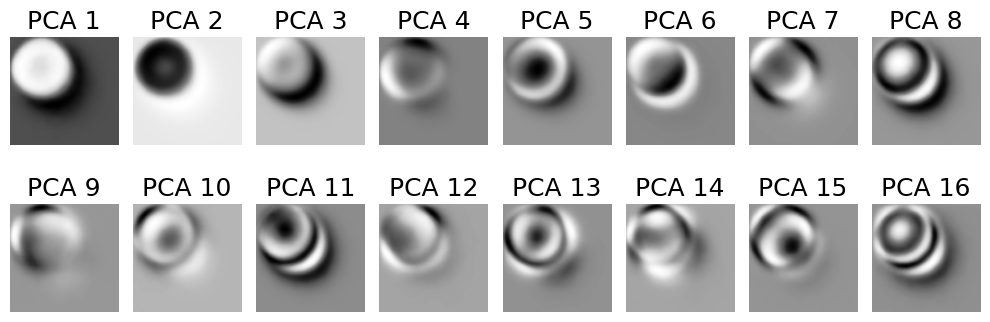

In [21]:
fig,axes = plt.subplots(2,8,figsize=(10,5))

for idx,ax in enumerate(axes.flat):
    reshaped = pca.components_[idx].reshape(100,100)
    ax.imshow(reshaped,cmap='Greys_r')
    ax.axis('off')
    ax.set_title(f'PCA {idx+1}',fontsize=18)
    plt.tight_layout()
plt.savefig('PCA_components.jpg')

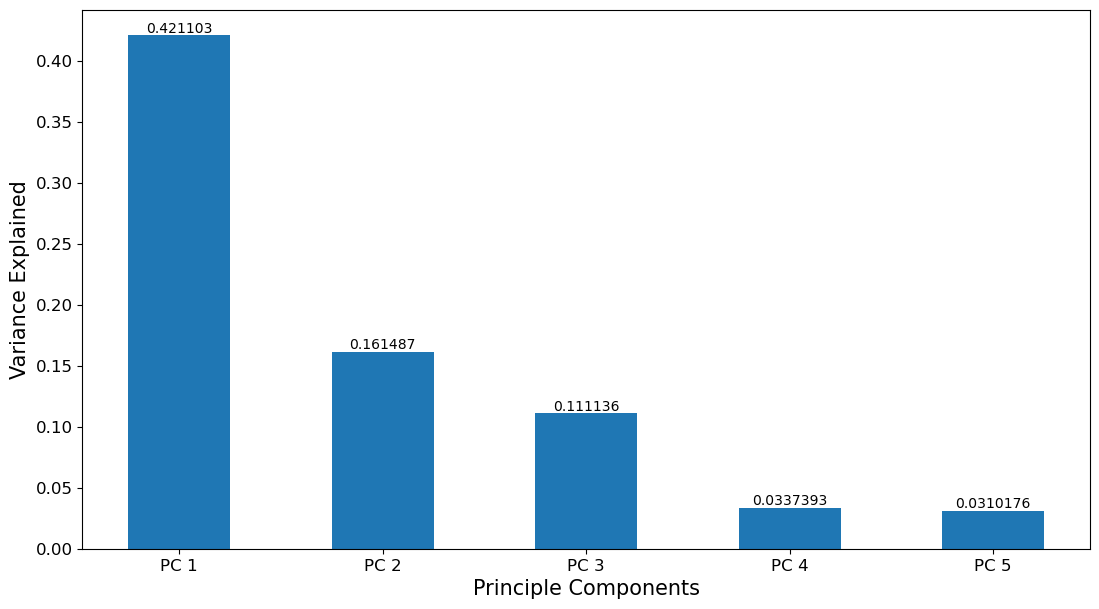

In [69]:
PC_values = np.arange(pca.n_components_)[:5]
labels = [f'PC {pc_val + 1}' for pc_val in list(PC_values)]
fig,ax = plt.subplots(figsize=(13,7))
rects = ax.bar(PC_values,pca.explained_variance_ratio_[:5],width=0.5
               ,label=pca.explained_variance_ratio_[:5])
ax.set_xticks(PC_values,labels=labels,fontsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.bar_label(rects)
plt.xlabel('Principle Components',fontsize=15)
plt.ylabel("Variance Explained",fontsize=15)
# plt.show()
plt.savefig('scree_plot.jpg')

In [41]:
reduced_feature_set = pca.transform(full_feature_set)

In [42]:
reduced_feature_set.shape

(27558, 248)

In [46]:
X_train,X_test,y_train,y_test = train_test_split(reduced_feature_set,total_labels,
                                                   stratify=total_labels,test_size=0.4,random_state=42)

In [47]:
X_train.shape,X_valid.shape

((16534, 248), (6201, 248))

In [28]:
params = {'C':[1000.0,3000.0,7000.0],'gamma':['scale','auto',0.0020,0.0075,0.0097]}

svm = SVC()

parameter_tuning = GridSearchCV(svm,param_grid=params,verbose=3,cv=3)

parameter_tuning.fit(X_train,y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END .............C=1000.0, gamma=scale;, score=0.857 total time=  28.3s
[CV 2/3] END .............C=1000.0, gamma=scale;, score=0.858 total time=  27.4s
[CV 3/3] END .............C=1000.0, gamma=scale;, score=0.860 total time=  27.3s
[CV 1/3] END ..............C=1000.0, gamma=auto;, score=0.888 total time=  51.8s
[CV 2/3] END ..............C=1000.0, gamma=auto;, score=0.888 total time=  51.5s
[CV 3/3] END ..............C=1000.0, gamma=auto;, score=0.891 total time=  51.1s
[CV 1/3] END .............C=1000.0, gamma=0.002;, score=0.876 total time=  48.4s
[CV 2/3] END .............C=1000.0, gamma=0.002;, score=0.878 total time=  47.7s
[CV 3/3] END .............C=1000.0, gamma=0.002;, score=0.884 total time=  47.8s
[CV 1/3] END ............C=1000.0, gamma=0.0075;, score=0.884 total time=  46.6s
[CV 2/3] END ............C=1000.0, gamma=0.0075;, score=0.882 total time=  46.4s
[CV 3/3] END ............C=1000.0, gamma=0.0075;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [1000.0, 3000.0, 7000.0],
                         'gamma': ['scale', 'auto', 0.002, 0.0075, 0.0097]},
             verbose=3)

In [29]:
parameter_tuning.best_estimator_

SVC(C=7000.0, gamma=0.002)

In [30]:
parameter_tuning.best_score_

0.8928270586416559

In [61]:
svm_model = SVC(C=7000.0,gamma=0.002,probability=True)



svm_model.fit(X_train,y_train)

SVC(C=7000.0, gamma=0.002, probability=True)

In [64]:


# accuracy = accuracy_score(y_test,preds)

# print("Accuracy : ",accuracy)

In [62]:
svm_preds = svm_model.predict(X_test)

print(classification_report(y_test,svm_preds))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      5512
         1.0       0.93      0.88      0.90      5512

    accuracy                           0.91     11024
   macro avg       0.91      0.91      0.91     11024
weighted avg       0.91      0.91      0.91     11024



In [64]:
pickle.dump(svm_model,open('svm_malaria_model','wb'))

In [65]:
# base_clf = SVC(C=7000.0,gamma=0.002)

clf = AdaBoostClassifier()

clf.fit(X_train,y_train)

AdaBoostClassifier()

In [66]:
ada_preds = clf.predict(X_test)

print(classification_report(y_test,ada_preds))

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      5512
         1.0       0.88      0.86      0.87      5512

    accuracy                           0.87     11024
   macro avg       0.87      0.87      0.87     11024
weighted avg       0.87      0.87      0.87     11024



In [67]:
pickle.dump(clf,open('ada_malaria_model','wb'))

In [68]:
ann_clf = MLPClassifier(verbose=True)

ann_clf.fit(X_train,y_train)

Iteration 1, loss = 0.63853487
Iteration 2, loss = 0.58502623
Iteration 3, loss = 0.55460072
Iteration 4, loss = 0.52041318
Iteration 5, loss = 0.48021795
Iteration 6, loss = 0.43714552
Iteration 7, loss = 0.39425661
Iteration 8, loss = 0.35521640
Iteration 9, loss = 0.31953044
Iteration 10, loss = 0.28939573
Iteration 11, loss = 0.26386534
Iteration 12, loss = 0.24109455
Iteration 13, loss = 0.22262104
Iteration 14, loss = 0.20569924
Iteration 15, loss = 0.19110296
Iteration 16, loss = 0.17871779
Iteration 17, loss = 0.16764949
Iteration 18, loss = 0.15749627
Iteration 19, loss = 0.14810417
Iteration 20, loss = 0.13994191
Iteration 21, loss = 0.13174618
Iteration 22, loss = 0.12493855
Iteration 23, loss = 0.11906753
Iteration 24, loss = 0.11280486
Iteration 25, loss = 0.10710722
Iteration 26, loss = 0.10231870
Iteration 27, loss = 0.09724558
Iteration 28, loss = 0.09310067
Iteration 29, loss = 0.08838700
Iteration 30, loss = 0.08480517
Iteration 31, loss = 0.08136104
Iteration 32, los

MLPClassifier(verbose=True)

In [69]:
ann_preds = ann_clf.predict(X_test)

print(classification_report(y_test,ann_preds))

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      5512
         1.0       0.92      0.89      0.91      5512

    accuracy                           0.91     11024
   macro avg       0.91      0.91      0.91     11024
weighted avg       0.91      0.91      0.91     11024



In [70]:
pickle.dump(ann_clf,open('ann_malaria_model','wb'))

In [55]:
rf_clf = RandomForestClassifier()

rf_params = {'n_estimators':[50,70,90,100],'criterion':['gini','entropy','log_loss']
            ,'max_depth':[1,2,4,8],'max_features':['sqrt','log2']}

rf_param_tuning = GridSearchCV(estimator=rf_clf,param_grid=rf_params,cv=3,verbose=3)

rf_param_tuning.fit(X_train,y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=50;, score=0.835 total time=   1.0s
[CV 2/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=50;, score=0.832 total time=   1.0s
[CV 3/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=50;, score=0.845 total time=   1.0s
[CV 1/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=70;, score=0.849 total time=   1.3s
[CV 2/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=70;, score=0.845 total time=   1.3s
[CV 3/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=70;, score=0.851 total time=   1.3s
[CV 1/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=90;, score=0.853 total time=   1.7s
[CV 2/3] END criterion=gini, max_depth=1, max_features=sqrt, n_estimators=90;, score=0.857 total time=   1.7s
[CV 3/3] END criterion=gini, max_depth=1, max_features=sqr

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
96 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/par

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 4, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 70, 90, 100]},
             verbose=3)

In [56]:
rf_param_tuning.best_estimator_

RandomForestClassifier(max_depth=8, max_features='sqrt')

In [71]:
rf_model = RandomForestClassifier(max_depth=8,max_features='sqrt')

rf_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features='sqrt')

In [72]:
rf_preds = rf_model.predict(X_test)

print(classification_report(y_test,rf_preds))

              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89      5512
         1.0       0.87      0.93      0.90      5512

    accuracy                           0.90     11024
   macro avg       0.90      0.90      0.90     11024
weighted avg       0.90      0.90      0.90     11024



In [73]:
pickle.dump(rf_model,open('rf_malaria_model','wb'))

In [60]:
# clf1 = SVC(C=7000.0,gamma=0.002)
# clf2 = RandomForestClassifier(max_depth=8,max_features='sqrt')
# clf3 = AdaBoostClassifier()
# clf4 = MLPClassifier()

# ensemble_clf = VotingClassifier(estimators=[('svm',clf1),('rf',clf2),('ada',clf3),('nn',clf4)]
#                                 ,verbose=True,voting='hard')

# ensemble_clf.fit(X_train,y_train)

[Voting] ...................... (1 of 4) Processing svm, total= 5.6min
[Voting] ....................... (2 of 4) Processing rf, total=  17.4s
[Voting] ...................... (3 of 4) Processing ada, total=  33.7s
[Voting] ....................... (4 of 4) Processing nn, total=  26.5s


VotingClassifier(estimators=[('svm', SVC(C=7000.0, gamma=0.002)),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     max_features='sqrt')),
                             ('ada', AdaBoostClassifier()),
                             ('nn', MLPClassifier())],
                 verbose=True)

In [61]:
# preds = ensemble_clf.predict(X_test)

# print(classification_report(y_true=y_test,y_pred=preds))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      5512
         1.0       0.93      0.90      0.91      5512

    accuracy                           0.92     11024
   macro avg       0.92      0.92      0.92     11024
weighted avg       0.92      0.92      0.92     11024



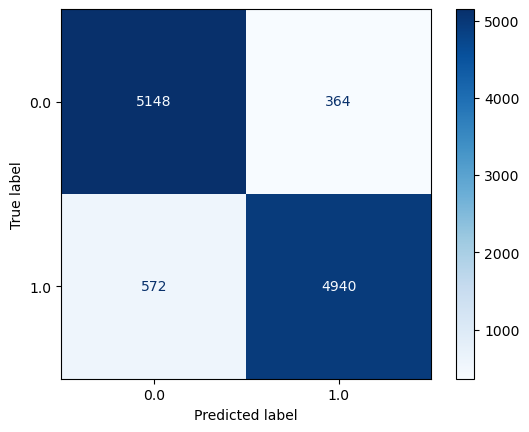

In [70]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=preds,cmap='Blues')

plt.savefig('ensemble_conf.jpg')

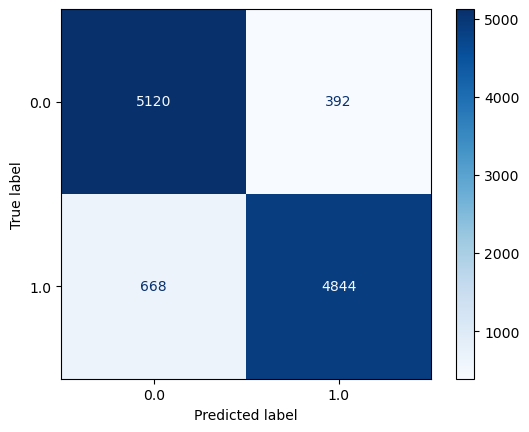

In [71]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=svm_preds,cmap='Blues')

plt.savefig('svm_conf.jpg')

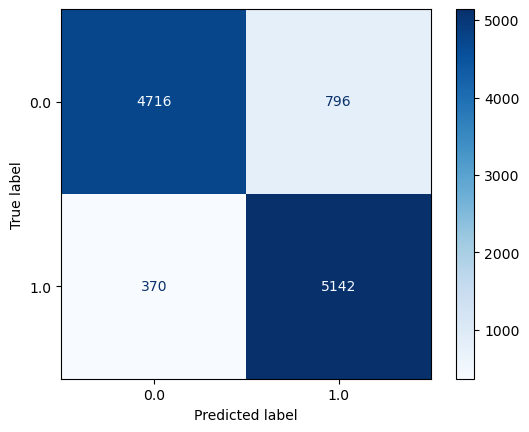

In [73]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=rf_preds,cmap='Blues')

plt.savefig('rf_conf.jpg')

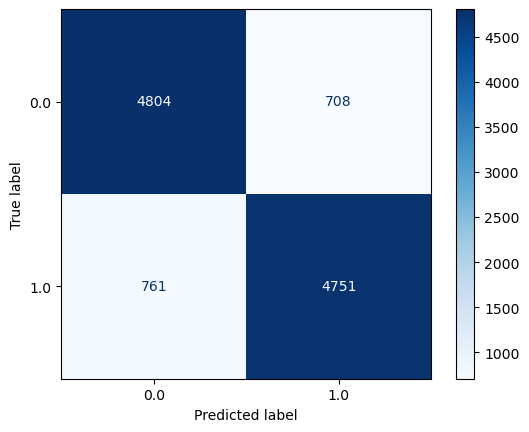

In [76]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=ada_preds,cmap='Blues')

plt.savefig('ada_conf.jpg')

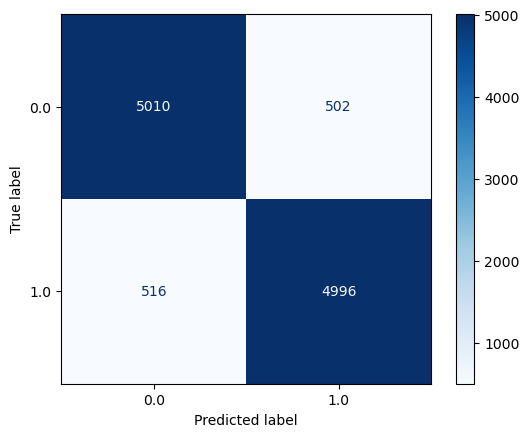

In [78]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=ann_preds,cmap='Blues')

plt.savefig('ann_conf.jpg')

In [94]:
# svm_auc = SVC(C=7000.0,gamma=0.002,probability=True,verbose=True)

# svm_auc.fit(X_train,y_train)

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

SVC(C=7000.0, gamma=0.002, probability=True, verbose=True)

In [74]:
svm_scores = svm_model.predict_proba(X_test)


In [77]:
fpr,tpr,_ = roc_curve(y_true=y_test,y_score=svm_scores[:,1])

print("FPR :",fpr)
print("TPR :",tpr)

FPR : [0.00000000e+00 5.44267054e-04 5.44267054e-04 ... 9.99092888e-01
 9.99092888e-01 1.00000000e+00]
TPR : [0.         0.01124819 0.01197388 ... 0.99981858 1.         1.        ]


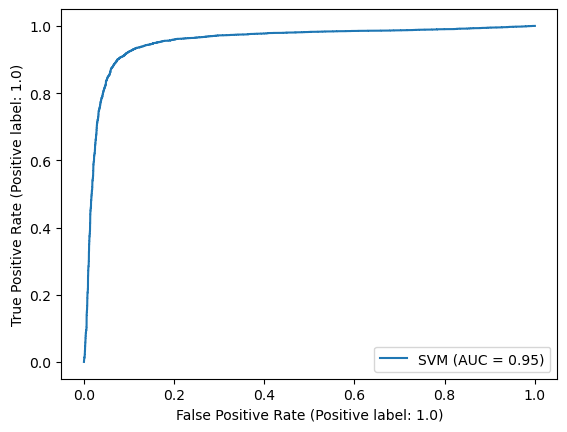

In [76]:
# fpr,tpr,_ = roc_curve(y_true=y_test,y_score=svm_scores[:,1],pos_label=svm_auc.classes_[1])
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=svm_scores[:,1],pos_label=svm_model.classes_[1]
                                ,name='SVM')

In [103]:
rf_scores = rf_model.predict_proba(X_test)


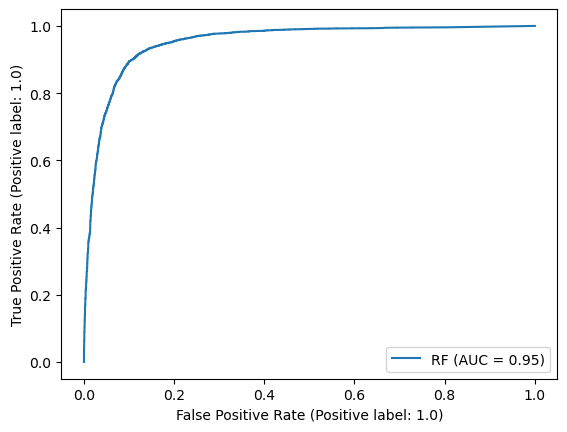

In [104]:
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=rf_scores[:,1],pos_label=rf_model.classes_[1]
                                ,name='RF')

In [106]:
ann_scores = ann_clf.predict_proba(X_test)

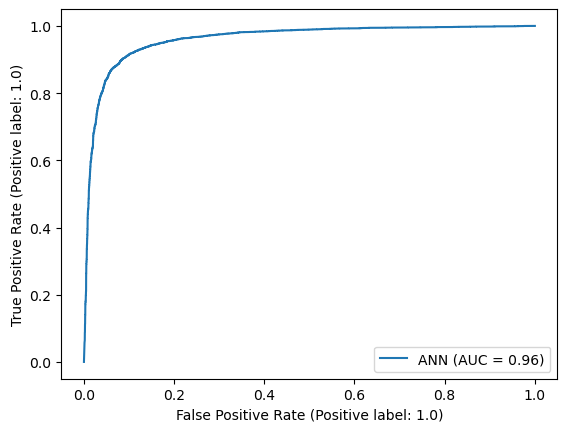

In [107]:
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=ann_scores[:,1],pos_label=ann_clf.classes_[1]
                                ,name='ANN')

In [108]:
ada_scores = clf.predict_proba(X_test)

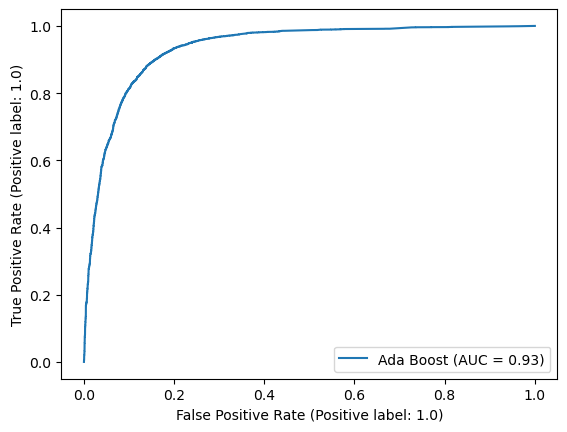

In [109]:
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=ada_scores[:,1],pos_label=clf.classes_[1]
                                ,name='Ada Boost')

In [78]:
auc_clf1 = SVC(C=7000.0,probability=True,gamma=0.002)
auc_clf2 = RandomForestClassifier(max_depth=8,max_features='sqrt')
auc_clf3 = AdaBoostClassifier()
auc_clf4 = MLPClassifier()

ensemble_clf_auc = VotingClassifier(estimators=[('svm',auc_clf1),('rf',auc_clf2)
                                                ,('ada',auc_clf3),('nn',auc_clf4)]
                                ,verbose=True,voting='soft')

In [79]:
ensemble_clf_auc.fit(X_train,y_train)

[Voting] ...................... (1 of 4) Processing svm, total=30.1min
[Voting] ....................... (2 of 4) Processing rf, total=  18.0s
[Voting] ...................... (3 of 4) Processing ada, total=  35.0s
[Voting] ....................... (4 of 4) Processing nn, total=  40.2s


VotingClassifier(estimators=[('svm',
                              SVC(C=7000.0, gamma=0.002, probability=True)),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     max_features='sqrt')),
                             ('ada', AdaBoostClassifier()),
                             ('nn', MLPClassifier())],
                 verbose=True, voting='soft')

In [81]:
ensemble_clf_soft_preds = ensemble_clf_auc.predict(X_test)

print(classification_report(y_test,ensemble_clf_soft_preds))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93      5512
         1.0       0.93      0.92      0.92      5512

    accuracy                           0.92     11024
   macro avg       0.92      0.92      0.92     11024
weighted avg       0.92      0.92      0.92     11024



In [82]:
ensemble_scores = ensemble_clf_auc.predict_proba(X_test)

In [84]:
pickle.dump(ensemble_clf_auc,open('ensemble_malaria_model','wb'))

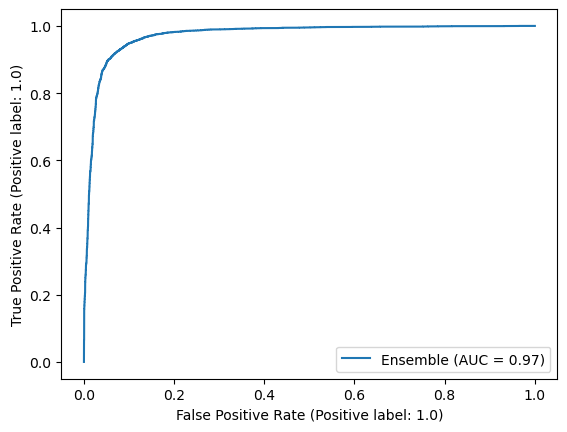

In [83]:
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=ensemble_scores[:,1]
                                 ,pos_label=ensemble_clf_auc.classes_[1]
                                ,name='Ensemble')

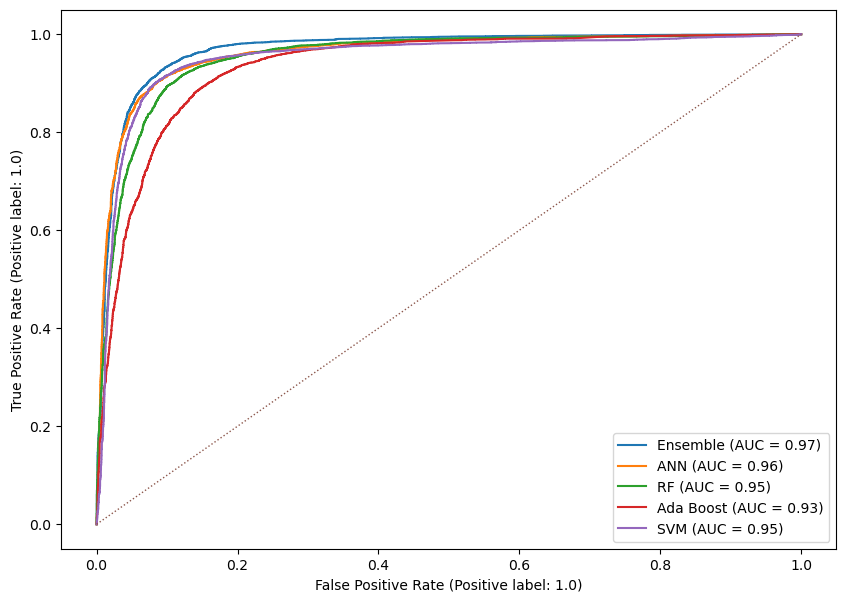

In [121]:
fig,axes = plt.subplots(figsize=(10,7))
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=ensemble_scores[:,1]
                                 ,pos_label=ensemble_clf_auc.classes_[1]
                                ,name='Ensemble',ax=axes)
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=ann_scores[:,1]
                                 ,pos_label=ann_clf.classes_[1]
                                ,name='ANN',ax=axes)
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=rf_scores[:,1]
                                 ,pos_label=rf_model.classes_[1]
                                ,name='RF',ax=axes)
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=ada_scores[:,1]
                                 ,pos_label=clf.classes_[1]
                                ,name='Ada Boost',ax=axes)
RocCurveDisplay.from_predictions(y_true=y_test,y_pred=svm_scores[:,1]
                                 ,pos_label=svm_auc.classes_[1]
                                ,name='SVM',ax=axes)

axes.plot([0,1],[0,1],linestyle=':',linewidth=1)
plt.savefig('AUC_ROC.jpg')

## Model Inference

In [8]:
!gdown 19FwUlo5pp8vsa0rhIguxEMkP2Wil2MXT --folder

Retrieving folder list
Processing file 1ELtASdFE_gYhRr6lF0ZYgn2CdYUjfF5p weights.zip
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ELtASdFE_gYhRr6lF0ZYgn2CdYUjfF5p
From (redirected): https://drive.google.com/uc?id=1ELtASdFE_gYhRr6lF0ZYgn2CdYUjfF5p&confirm=t&uuid=5e7da7c2-9cf5-4f31-b502-f4309643885c
To: /kaggle/working/Malaria Detection/weights.zip
100%|██████████████████████████████████████| 40.5M/40.5M [00:00<00:00, 67.9MB/s]
Download completed


In [9]:
!unzip '/kaggle/working/Malaria Detection/weights.zip'

Archive:  /kaggle/working/Malaria Detection/weights.zip
  inflating: ada_malaria_model       
  inflating: ann_malaria_model       
  inflating: ensemble_malaria_model  
  inflating: pca_malaria_weights     
  inflating: rf_malaria_model        
  inflating: svm_malaria_model       


In [10]:
pca_path = '/kaggle/working/pca_malaria_weights'
ensemble_path = '/kaggle/working/ensemble_malaria_model'
pca_transform = pickle.load(open(pca_path,'rb'))
ensemble_model = pickle.load(open(ensemble_path,'rb'))

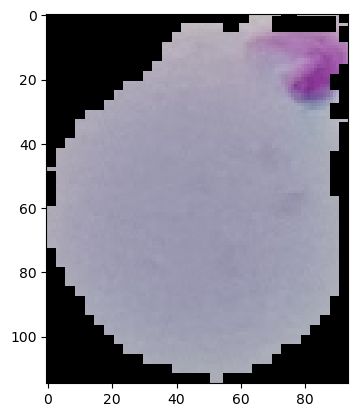

In [13]:
sample_parasitized = parasitized[-1]

img = Image.open(sample_parasitized)
plt.imshow(img)
plt.savefig('parasitized_sample.jpg')

In [14]:
img = feature_extraction(sample_parasitized)
img = np.array([img])
transformed_img = pca_transform.transform(img)
prediction = ensemble_model.predict(transformed_img)

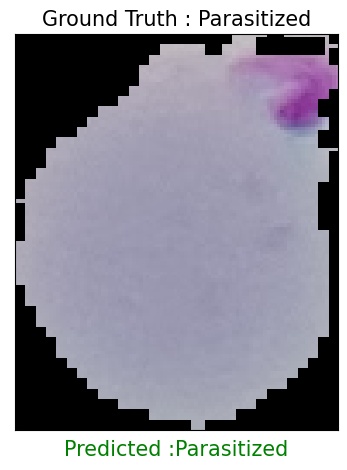

In [19]:
img = Image.open(sample_parasitized)
label = 'Parasitized' if prediction == 1.0 else 'Uninfected'
color = 'green' if label == 'Parasitized' else 'red'

plt.imshow(img)
plt.xlabel(f'Predicted :{label}',color=color,fontsize=15)
plt.xticks([])
plt.yticks([])
    
plt.title(f'Ground Truth : Parasitized',fontsize=15)
plt.tight_layout()
plt.savefig('parasitized_predicted.jpg')

In [7]:
sample_parasitized = parasitized[-5:]
sample_uninfected = uninfected[-5:]

In [8]:
total_sample = sample_parasitized + sample_uninfected

In [9]:
test_samples = random.sample(total_sample,len(total_sample))

In [15]:
predictions = []
for path in test_samples:
    img = feature_extraction(path)
    img = np.array([img])
    transformed_img = pca_transform.transform(img)
    prediction = ensemble_model.predict(transformed_img)
    predictions.append(prediction)

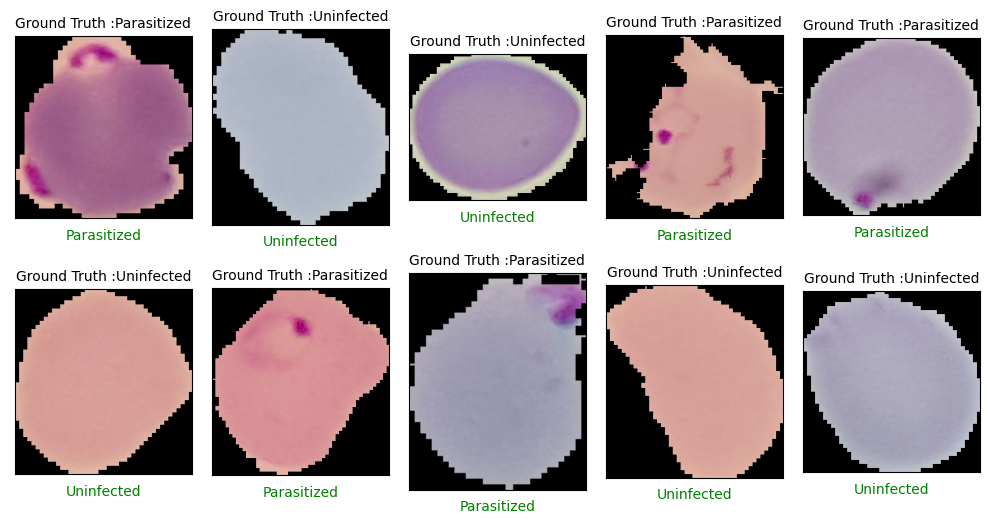

In [20]:
fig,axes = plt.subplots(2,5,figsize=(10,6))
for path,ax,pred in zip(test_samples,axes.flat,predictions):
    path = Path(path)
    parent = path.parent.parts[-1]
    img = Image.open(path)
    label = 'Parasitized' if pred == 1.0 else 'Uninfected'
    color = 'green' if label == parent else 'red'

    ax.imshow(img)
    ax.set_xlabel(label,color=color,fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(f'Ground Truth :{parent}',fontsize=10)
    plt.tight_layout()

plt.savefig('Inference.jpg')

In [27]:


print(prediction)

[1.]
